### Advanced Machine Learning Methods for Chronic Kidney Disease Identification

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score

In [ ]:
# read dataset from a public Google Drive File

file_link = 'https://drive.google.com/file/d/1YQh3TIzoLOGq9B45tHg_wTyJwsYJCpZf/view?usp=sharing'

# get the id part of the file
id = file_link.split("/")[-2]

# creating a new link using the id for better readability of csv file in pandas
new_link = f'https://drive.google.com/uc?id={id}'
df = pd.read_csv(new_link)

# let's look at the first few instances
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [ ]:
df.shape

(400, 26)

In [ ]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

### Data Pre-Processing

In [ ]:
df[['htn','dm','cad','pe','ane']]=df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification']=df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [ ]:
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)

In [ ]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# '?' character remove process in the dataset
for i in ['rc','wc','pcv']:
    df[i] = df[i].str.extract('(\d+)').astype(float)
# Filling missing numeric data in the dataset with mean
for i in ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','rc','wc','pcv']:
    df[i].fillna(df[i].mean(),inplace=True)

In [ ]:
df.isnull().sum()

age        0
bp         0
sg         0
al         0
su         0
rbc      152
pc        65
pcc        4
ba         4
bgr        0
bu         0
sc         0
sod        0
pot        0
hemo       0
pcv        0
wc         0
rc         0
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [ ]:
df = df.dropna(axis=1)
df.shape

(400, 15)

In [ ]:
df.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wc       0
rc       0
class    0
dtype: int64

In [ ]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.528754,4.627244,15.4,44.0,7800.0,5.000000,1.0
1,7.0,50.0,1.020,4.0,0.0,148.036517,18.0,0.8,137.528754,4.627244,11.3,38.0,6000.0,4.241636,1.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.528754,4.627244,9.6,31.0,7500.0,4.241636,1.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.000000,1.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.528754,4.627244,11.6,35.0,7300.0,4.000000,1.0


In [ ]:
#Data preprocessing
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)

#Splitting the dataset in to training and testing set
X_train , X_test , y_train , y_test   = train_test_split(X,y,test_size = 0.2 , random_state=111)

## Model Training & Testing

### Random Forest classification

In [ ]:
#fitting Random Forest classification to the training set
rfc = RandomForestClassifier(n_estimators=10 , criterion='entropy',random_state=111)
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=111)

In [ ]:
#predictin the test result
y_pred_rfc = rfc.predict(X_test)

In [ ]:
print("Train score - " + str(rfc.score(X_train, y_train)))
print("Test score - " + str(rfc.score(X_test, y_test)))

Train score - 1.0
Test score - 0.95


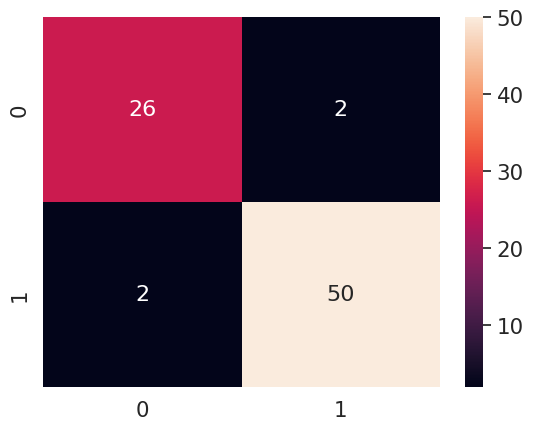

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test,y_pred_rfc)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#print(classification_report(y_test, y_pred_rfc))
accuracy = accuracy_score(y_test, y_pred_rfc)
f1 = f1_score(y_test, y_pred_rfc, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.95
F1 Score: 0.95


### Logistic Regression

In [ ]:
# Training the Logistic Regression model on the Training set

lg = LogisticRegression(random_state = 111)
lg.fit(X_train, y_train)

LogisticRegression(random_state=111)

In [ ]:
#predictin the test result
y_pred_lg = lg.predict(X_test)

In [ ]:
print("Train score - " + str(lg.score(X_train, y_train)))
print("Test score - " + str(lg.score(X_test, y_test)))

Train score - 0.990625
Test score - 0.9625


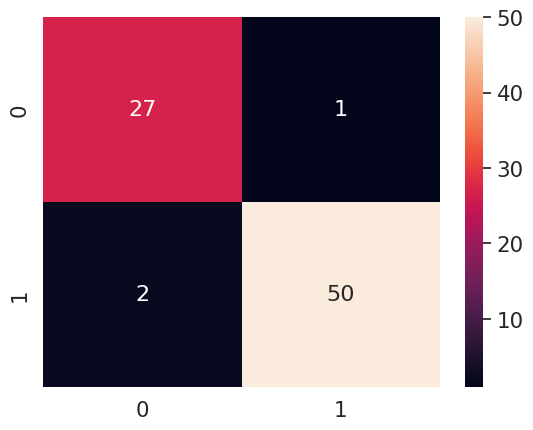

In [ ]:
#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lg = confusion_matrix(y_test,y_pred_lg)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_lg, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#print(classification_report(y_test, y_pred_lg))
accuracy = accuracy_score(y_test, y_pred_lg)
f1 = f1_score(y_test, y_pred_lg, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.9625
F1 Score: 0.9626469085334696


### K-Nearest Neighbors Classifier

In [ ]:
#fitting KNN to the training set

knn= KNeighborsClassifier(n_neighbors=5 , metric='minkowski',p=2  )
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [ ]:
#predictin the test result
y_pred_knn = knn.predict(X_test)

In [ ]:
print("Train score - " + str(knn.score(X_train, y_train)))
print("Test score - " + str(knn.score(X_test, y_test)))

Train score - 0.978125
Test score - 0.975


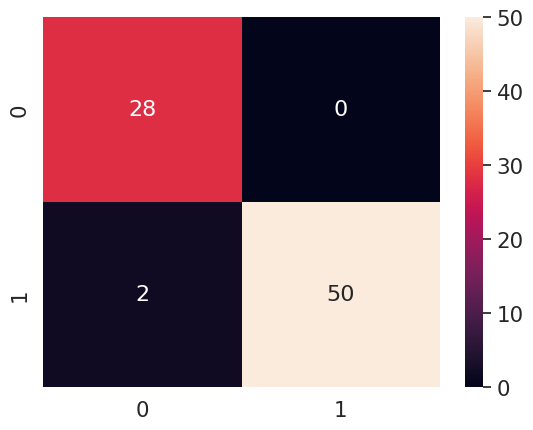

In [ ]:
#Making the Confusion Matrix
cm_knn = confusion_matrix(y_test,y_pred_knn)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_knn, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#print(classification_report(y_test, y_pred_knn))
accuracy = accuracy_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.975
F1 Score: 0.9751859364435429


### Support Vector Machine

In [ ]:
#fitting SVM to the training set
svm = SVC(kernel='linear', random_state=111)
svm.fit(X_train,y_train)

SVC(kernel='linear', random_state=111)

In [ ]:
#predictin the test result
y_pred_svm = svm.predict(X_test)

In [ ]:
print("Train score - " + str(svm.score(X_train, y_train)))
print("Test score - " + str(svm.score(X_test, y_test)))

Train score - 0.99375
Test score - 0.9625


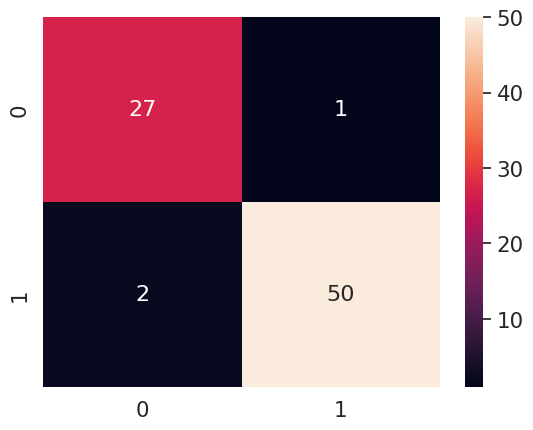

In [ ]:
#Making the Confusion Matrix
cm_svm = confusion_matrix(y_test,y_pred_svm)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_svm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#print(classification_report(y_test, y_pred_svm))
accuracy = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.9625
F1 Score: 0.9626469085334696


### Kernel Navie Bayes

In [ ]:
#fitting kernal Navie bayes to the training set
knb = GaussianNB()
knb.fit(X_train,y_train)

GaussianNB()

In [ ]:
#predictin the test result
y_pred_knb = knb.predict(X_test)

In [ ]:
print("Train score - " + str(knb.score(X_train, y_train)))
print("Test score - " + str(knb.score(X_test, y_test)))

Train score - 0.953125
Test score - 0.95


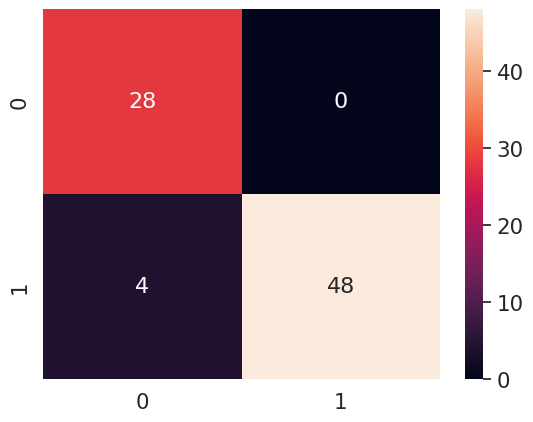

In [ ]:
#Making the Confusion Matrix
cm_knb = confusion_matrix(y_test,y_pred_knb)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_knb, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#print(classification_report(y_test, y_pred_knb))
accuracy = accuracy_score(y_test, y_pred_knb)
f1 = f1_score(y_test, y_pred_knb, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.95
F1 Score: 0.9506666666666668
